In [1]:
import os
import time
from datetime import datetime
import numpy as np
#import matplotlib.pyplot as plt
from collections import deque
import gym
import pandas as pd
from pathlib import Path
import sys
import random
import tensorflow as tf
from sqlalchemy import create_engine

from environments import PortfolioEnvironment, PortfolioEnvironmentTargetReward

In [2]:
engine = create_engine(f'mysql+pymysql://{os.environ["MYSQL_USER"]}:{os.environ["MYSQL_PASSWORD"]}@{os.environ["MYSQL_SERVER"]}:{os.environ["MYSQL_PORT"]}/tfm')

In [3]:
model_path = './models/26_05_2022_14_12_57' 
max_steps = 200
fee = 0.25/100
window = 50

In [4]:
tickers = "('AAPL','AMZN','BA','COIN','FB','GM','GOLD','GOOG','JNJ','JPM','KO','MSFT','NKE','NVDA','PFE','SPY','SQ','TSLA','V','WMT','XOM')"

In [5]:
#tickers = ['AAPL','AMZN','GM','GOLD','JPM','MSFT','NVDA','KO','TSLA','V','XOM','WMT']
assets_data_list = []
assets_data_list_test = []
tickers = {v: k for k, v in engine.execute(f"SELECT id,ticker FROM tickers where ticker in {tickers} order by id asc").fetchall()}
for t in tickers.keys():
    #assets_data_list.append(pd.read_csv(f'./data/{t}.csv'))
    assets_data_list.append(pd.read_sql(f"SELECT close,high,low from historical_30min inner join tickers on ticker_id = tickers.id where ticker = '{t}' order by time asc",engine))
    assets_data_list_test.append(assets_data_list[-1].tail(max_steps+window))
    assets_data_list[-1] = assets_data_list[-1].iloc[:assets_data_list[-1].shape[0]-max_steps,]

target = pd.read_sql("select close from historical_hour inner join tickers on ticker_id = tickers.id where ticker = 'SPY' order by time asc",engine)

In [6]:
import matplotlib.pyplot as plt
from environments import PortfolioEnvironmentTest,PortfolioEnvironmentTargetRewardTest

In [27]:
env2 = PortfolioEnvironmentTest(tickers.keys(),assets_data_list_test,fee=fee,look_back_window=window)
policy = MarkowitzAgent()
#action = np.clip(np.random.normal(2,3,size=env.action_space.shape[0]),0,None)
#action = action/action.sum()
state = env2.reset()
done = False
total_reward = 0
infos = []
#state, reward, done, info = env2.step(action)
#state["data"].shape
while not done:
    action = policy.select_action(state)
    #print(action)
    state, reward, done, info = env2.step(action)
    #print(reward)
    total_reward += reward
    infos.append(info)
    #print(action)

print(total_reward)

-10060.408024413307


In [28]:
p_evolution = [1.0]
for info in infos:
    p_evolution.append(info['value'])
    

Grafico 30 minutos

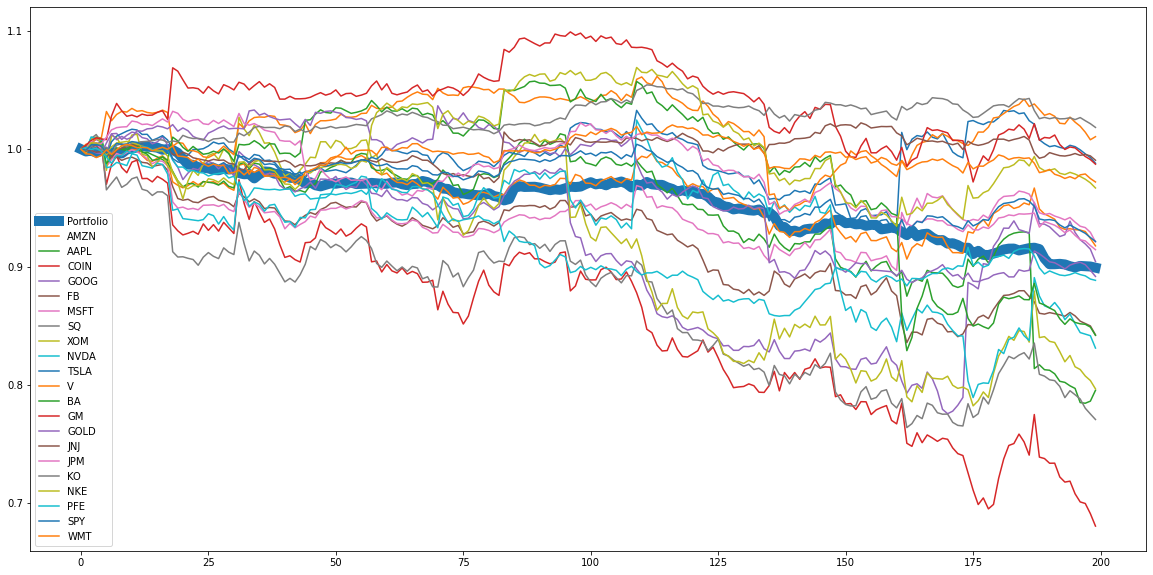

In [29]:
plt.figure(figsize=(20,10))
pd.Series(p_evolution).reset_index(drop=True).plot(linewidth=10)
for a in assets_data_list_test:
    (a.iloc[50:,0]/a.iloc[50,0]).reset_index(drop=True).plot()
plt.legend(['Portfolio']+list(tickers.keys()),loc=3)

Grafico 1 hora

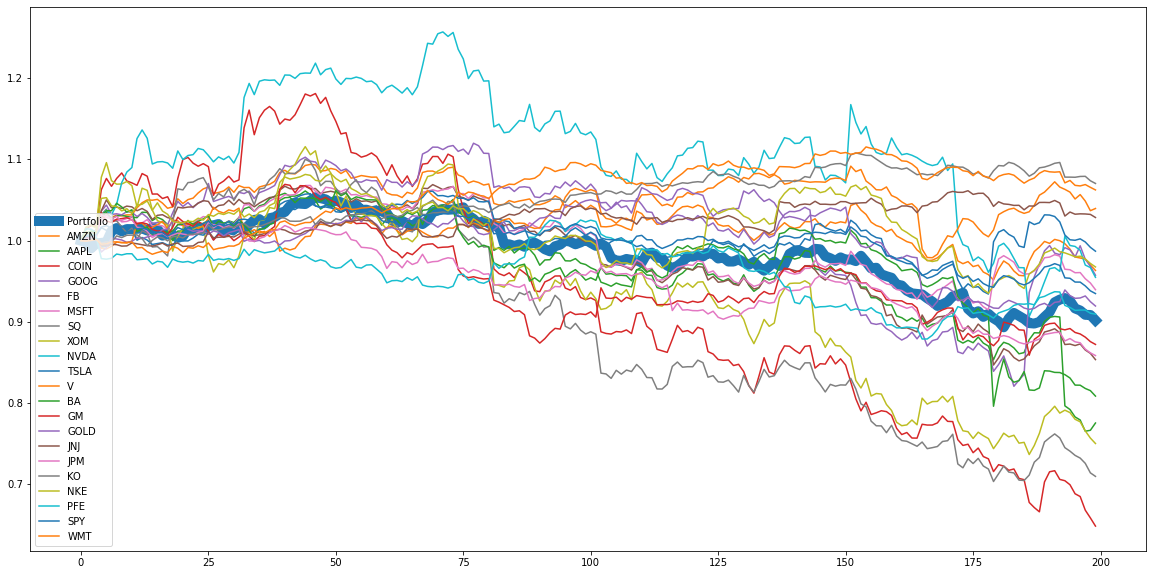

In [20]:
plt.figure(figsize=(20,10))
pd.Series(p_evolution).reset_index(drop=True).plot(linewidth=10)
for a in assets_data_list_test:
    (a.iloc[50:,0]/a.iloc[50,0]).reset_index(drop=True).plot()
plt.legend(['Portfolio']+list(tickers.keys()),loc=3)

In [39]:
p_evolution = [1.0]
for info in infos:
    p_evolution.append(info['value'])

<AxesSubplot:>

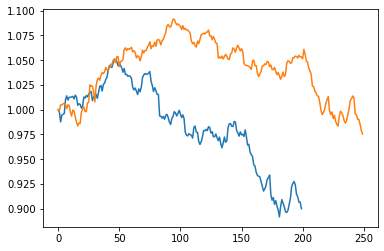

In [40]:
pd.Series(p_evolution).reset_index(drop=True).plot()
pd.Series(target_test/target_test[0]).plot()

In [25]:
from scipy.optimize import minimize

class MarkowitzAgent():
    def __init__(self,rf=0.01):
        self.rf= rf
        self.data = None
    
    def select_action(self,state):
        self.data = state["data"][:,:,0].T
        length = self.data.shape[1]+1
        cons = ({'type':'eq','fun':self._sum_of_weights_check})
        bounds = tuple(zip([0],[0.2])) + tuple(zip([0]*(length-1),[1]*(length-1)))
        start_weights = [1/length] * (length)
        return minimize(self._minimize_function,start_weights,method='SLSQP',bounds=bounds,constraints=cons).x
    
    def _stock_return_volatility(self,data,weights):
        weights = np.array(weights)
        log_ret = np.log(data[1:]/data[:-1])
        log_ret = np.concatenate((np.ones(shape=(log_ret.shape[0],1)),log_ret),axis=1)
        n_periods = len(data)
        ret = np.sum((np.mean(log_ret,axis=0)*weights)*n_periods)
        vol = np.sqrt(np.dot(weights,np.dot(np.cov(log_ret.T)*n_periods,weights.T)))
        SR = (ret-self.rf)/vol
        return SR
    
    def _minimize_function(self,weights):
        return self._stock_return_volatility(data=self.data,weights=weights)*-1
    
    def _sum_of_weights_check(self,weights):
        return np.sum(weights)-1
    
    
    
    
    
    

In [16]:
env2 = PortfolioEnvironmentTest(tickers.keys(),assets_data_list_test,fee=fee,look_back_window=window)
state = env2.reset()
data = state["data"][:,:,0].T
n_periods = len(data)
weights = [1/data.shape[1]] * data.shape[1]
weights = np.array(weights)
log_ret = np.log(data[1:]/data[:-1])
np.concatenate((np.ones(shape=(log_ret.shape[0],1)),log_ret),axis=1)
#log_ret.shape

array([[ 1.00000000e+00, -4.62133912e-04, -3.59130520e-03, ...,
        -1.94628321e-03, -1.28480624e-03, -2.65005964e-04],
       [ 1.00000000e+00,  6.85229987e-03,  2.72677780e-03, ...,
         4.47080150e-03,  3.93779683e-03,  5.96164692e-04],
       [ 1.00000000e+00,  2.04482872e-02,  1.82280507e-02, ...,
        -1.74121586e-02,  3.68040437e-03, -1.92224896e-03],
       ...,
       [ 1.00000000e+00,  1.17102888e-03, -4.26078401e-03, ...,
         1.46869863e-03,  9.00252071e-05,  1.99248065e-03],
       [ 1.00000000e+00, -3.57593370e-03, -1.55213030e-03, ...,
         2.01594497e-03, -2.70099939e-04,  4.61243611e-03],
       [ 1.00000000e+00,  5.38832275e-03,  8.22901987e-03, ...,
         6.75123447e-03,  5.29862039e-03,  3.82751169e-03]])

In [19]:
covariance = np.cov(log_ret.T)*n_periods

In [23]:
ret = np.sum((np.mean(log_ret,axis=0)*weights)*n_periods)
vol = np.sqrt(np.dot(weights,np.dot(np.cov(log_ret.T)*n_periods,weights.T)))
SR = (ret-0.01)/vol

In [35]:
np.array([0.0294,0.0308,0.0938,0.0216])[-1]

0.0216

In [24]:
SR

-1.3344740128734962

In [14]:
state["data"][:,:,0].T

array([[1.01139019, 1.04674235, 1.12861561, ..., 0.93526096, 1.0115097 ,
        0.96116134],
       [1.0109229 , 1.04298993, 1.1236432 , ..., 0.93344244, 1.01021094,
        0.96090666],
       [1.01787383, 1.04583781, 1.13364866, ..., 0.93762502, 1.01419678,
        0.96147969],
       ...,
       [0.99818925, 0.99334535, 0.98738706, ..., 0.99127114, 0.9949841 ,
        0.99159557],
       [0.99462617, 0.99180475, 0.98235401, ..., 0.9932715 , 0.99471539,
        0.9961798 ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ]])

In [24]:
length = 6
tuple(zip([0],[0.2])) + tuple(zip([0]*(length-1),[1]*(length-1)))

((0, 0.2), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1))